In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from itertools import combinations_with_replacement

# ==============================================================================
# 0. Helper Functions (Target Generation)
# ==============================================================================
def generate_sierpinski_fractal(iterations=7, device='cpu'):
    """
    Generates a discrete fractal point cloud (Sierpinski triangle) using IFS.
    """
    v1 = torch.tensor([0.0, 0.0], device=device)
    v2 = torch.tensor([1.0, 0.0], device=device)
    v3 = torch.tensor([0.5, np.sqrt(3)/2], device=device)
    current_points = torch.stack([v1, v2, v3])

    for i in range(iterations):
        transformed_1 = current_points * 0.5
        transformed_2 = current_points * 0.5 + v2 * 0.5
        transformed_3 = current_points * 0.5 + v3 * 0.5
        all_new_points = torch.cat([transformed_1, transformed_2, transformed_3], dim=0)
        current_points = torch.unique(all_new_points, dim=0)

    return current_points.cpu().numpy()


def generate_dragon_curve(iterations=8, device='cpu'):
    """
    Generates the classic Dragon Curve (scaling = 1/sqrt(2) approx 0.707).
    """
    rot_plus  = torch.tensor([[ 0.5, -0.5], [ 0.5,  0.5]], device=device)
    rot_minus = torch.tensor([[ 0.5,  0.5], [-0.5,  0.5]], device=device)
    trans     = torch.tensor([0.5, -0.5], device=device)

    pts = torch.tensor([[0.,0.],[1.,0.]], device=device)
    for _ in range(iterations):
        left  = torch.matmul(pts, rot_plus.T)
        right = torch.matmul(torch.flip(pts, dims=[0]), rot_minus.T) + trans
        pts   = torch.unique(torch.cat([left, right], dim=0), dim=0)
    return pts

def generate_dragon2_curve(iterations=8, target_scale=0.6, device='cpu', tolerance=1e-6):
    """
    Generate scaled dragon curve with duplicate point removal (considering floating-point tolerance)

    Parameters:
        iterations: Number of iterations (default 8)
        target_scale: Target scaling factor (default 0.6)
        device: Computation device ('cpu' or 'cuda')
        tolerance: Floating-point tolerance (default 1e-6)

    Returns:
        numpy array: Deduplicated fractal point set
    """
    # Base transformation matrices (corresponding to scale factor 1/√2 ≈ 0.707)
    rot_plus_base = torch.tensor([[0.5, -0.5], [0.5, 0.5]], device=device)
    rot_minus_base = torch.tensor([[0.5, 0.5], [-0.5, 0.5]], device=device)
    trans_base = torch.tensor([0.5, -0.5], device=device)

    # Calculate contraction factor
    base_scale = 1 / np.sqrt(2)
    contraction_factor = target_scale / base_scale

    # Apply contraction factor
    rot_plus = rot_plus_base * contraction_factor
    rot_minus = rot_minus_base * contraction_factor
    trans = trans_base * contraction_factor
    pts = torch.tensor([[0., 0.], [1., 0.]], device=device) * contraction_factor

    # Iteratively generate fractal point set
    for _ in range(iterations):
        pts_flipped = torch.flip(pts, dims=[0])
        left = torch.matmul(pts, rot_plus.T)
        right = torch.matmul(pts_flipped, rot_minus.T) + trans

        # Combine point sets and deduplicate (considering floating-point precision)
        all_pts = torch.cat([left, right], dim=0)

        # Round to tolerance precision before deduplication
        rounded_pts = torch.round(all_pts / tolerance) * tolerance
        unique_pts, inverse_indices = torch.unique(
            rounded_pts,
            dim=0,
            return_inverse=True
        )

        # Use original values (not rounded) but maintain uniqueness
        pts = unique_pts

    # Return deduplicated point set
    return pts.cpu().numpy()


# ==============================================================================
# 1. Loss Functions (DCD, Chamfer, Multi-Scale Chamfer)
# ==============================================================================
def chamfer_distance(p1: torch.Tensor, p2: torch.Tensor) -> torch.Tensor:
    if p1.shape[0] == 0 or p2.shape[0] == 0:
        return torch.tensor(1.0, device=p1.device, requires_grad=True)
    p1, p2 = p1.float(), p2.float()
    dist_matrix_squared = torch.cdist(p1, p2).pow(2)
    dist1, _ = dist_matrix_squared.min(dim=1)
    dist2, _ = dist_matrix_squared.min(dim=0)
    return dist1.mean() + dist2.mean()

def multi_scale_chamfer(p1, p2, scales=[1.0, 0.5, 0.25]):
    if p1.shape[0] == 0 or p2.shape[0] == 0:
        return torch.tensor(1.0, device=p1.device, requires_grad=True)
    loss = 0
    for s in scales:
        step1 = int(1 / s) if s < 1 and p1.shape[0] > int(1/s) else 1
        step2 = int(1 / s) if s < 1 and p2.shape[0] > int(1/s) else 1
        loss += chamfer_distance(p1[::step1], p2[::step2]) * s
    return loss

def calculate_dcd_2d(p1: torch.Tensor, p2: torch.Tensor, alpha: int = 60, n_lambda: int = 5) -> torch.Tensor:
    if p1.shape[0] == 0 or p2.shape[0] == 0:
        return torch.tensor(1.0, device=p1.device, requires_grad=True)
    p1, p2 = p1.float(), p2.float()
    N, M = p1.shape[0], p2.shape[0]
    dist_squared = torch.cdist(p1, p2).pow(2)
    p1_to_p2_dists, p1_to_p2_idx = dist_squared.min(dim=1)
    p2_to_p1_dists, p2_to_p1_idx = dist_squared.min(dim=0)
    n_p2, n_p1 = torch.zeros(M, device=p1.device), torch.zeros(N, device=p1.device)
    n_p2.scatter_add_(0, p1_to_p2_idx, torch.ones(N, device=p1.device))
    n_p1.scatter_add_(0, p2_to_p1_idx, torch.ones(M, device=p1.device))
    n_p2_gathered, n_p1_gathered = n_p2.gather(0, p1_to_p2_idx), n_p1.gather(0, p2_to_p1_idx)
    epsilon = 1e-8
    weights_p2, weights_p1 = n_p2_gathered.pow(n_lambda) + epsilon, n_p1_gathered.pow(n_lambda) + epsilon
    term1 = (1 - (1 / weights_p2) * torch.exp(-alpha * p1_to_p2_dists)).mean()
    term2 = (1 - (1 / weights_p1) * torch.exp(-alpha * p2_to_p1_dists)).mean()
    return (term1 + term2) / 2

# ==============================================================================
# 2. Helper Functions (Matrix Construction & Initialization)
# ==============================================================================
def make_rotation_matrix(theta):
    cos_t, sin_t = torch.cos(theta), torch.sin(theta)
    return torch.stack([torch.stack([cos_t, -sin_t], dim=-1), torch.stack([sin_t, cos_t], dim=-1)], dim=-2)

def make_diagonal_matrix(d1, d2):
    zero = torch.zeros_like(d1)
    return torch.stack([torch.stack([d1, zero], dim=-1), torch.stack([zero, d2], dim=-1)], dim=-2)

def make_matrices_from_svdformat(params):
    theta1, theta2, sigma1, sigma2, d1, d2 = torch.chunk(params, 6, dim=-1)
    r_mat1 = make_rotation_matrix(theta1.squeeze(-1) * 2 * math.pi)
    r_mat2 = make_rotation_matrix(theta2.squeeze(-1) * 2 * math.pi)
    sig_mat = make_diagonal_matrix(torch.sigmoid(sigma1.squeeze(-1)), torch.sigmoid(sigma2.squeeze(-1)))
    d_mat = make_diagonal_matrix(d1.squeeze(-1).sign() - d1.squeeze(-1).detach() + d1.squeeze(-1),
                                 d2.squeeze(-1).sign() - d2.squeeze(-1).detach() + d2.squeeze(-1))
    return torch.matmul(torch.matmul(r_mat1, sig_mat), r_mat2) @ d_mat

def build_fractal_model_svdformat(num_transforms, base_sigma):
    if np.isscalar(base_sigma):
        sigma_list = [float(base_sigma)] * num_transforms
    else:
        assert len(base_sigma) == num_transforms, f"base_sigma length must equal num_transforms"
        sigma_list = list(map(float, base_sigma))
    ifs_w, ifs_b = nn.Embedding(num_transforms, 6), nn.Embedding(num_transforms, 2)
    for index in range(num_transforms):
        theta1, theta2 = np.random.rand(), np.random.rand()
        b = (torch.rand(2, 1) - 0.5) * 0.5
        p1, p2 = (np.random.rand() - 0.5), (np.random.rand() - 0.5)
        sigma_c = sigma_list[index]
        sigma1, sigma2 = sigma_c + p1, sigma_c + p2
        d1, d2 = 0.5, 0.5
        params = torch.tensor([theta1, theta2, sigma1, sigma2, d1, d2], dtype=torch.float32)
        ifs_w.weight.data[index].copy_(params)
        ifs_b.weight.data[index].copy_(b.view(2))
    return ifs_w, ifs_b

# ==============================================================================
# 3. Neural Network Model
# ==============================================================================
class IFSNet(nn.Module):
    def __init__(self, num_ifs=3, base_sigma=(0.0, 0.0, 0.0)):
        super(IFSNet, self).__init__()
        self.num_ifs = num_ifs
        self.ifs_w, self.ifs_b = build_fractal_model_svdformat(
            num_transforms=self.num_ifs, base_sigma=base_sigma
        )

    def forward(self, p_in):
        target_num_points = p_in.shape[0]
        if target_num_points == 0:
            return torch.empty(0, p_in.shape[1], device=p_in.device)

        device = p_in.device

        w_params, b_params = self.ifs_w.weight, self.ifs_b.weight
        w_matrices = make_matrices_from_svdformat(w_params)
        output_clouds = [torch.matmul(p_in, w_matrices[i].T) + b_params[i] for i in range(self.num_ifs)]

        combined_cloud = torch.cat(output_clouds, dim=0)

        if combined_cloud.shape[0] == 0:
            return torch.empty(0, p_in.shape[1], device=device)

        num_available_points = combined_cloud.shape[0]
        sample_indices = torch.randperm(num_available_points, device=device)[:target_num_points]

        sampled_cloud = combined_cloud[sample_indices]

        return sampled_cloud

# ==============================================================================
# 4. Training Loop
# ==============================================================================
def run_training_experiment(target_shape, loss_function_name, num_ifs, sigma_combinations,
                            search_epochs, final_epochs, learning_rate, noise_level):
    GRAD_CLIP_VALUE = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Experiment on device: {device} ---")
    print(f"Target: {target_shape.upper()}, Loss: {loss_function_name.upper()}, Num IFS: {num_ifs}")
    print(f"LR: {learning_rate}, Noise: {noise_level}")

    print("\nGenerating target data...")
    if target_shape == 'sierpinski':
        np_pts = generate_sierpinski_fractal(iterations=7, device=device)
    elif target_shape == 'dragon':
        np_pts = generate_dragon_curve(iterations=8, device=device).cpu().numpy()
    elif target_shape == 'dragon2':
        np_pts = generate_dragon2_curve(iterations=12,target_scale=0.6)
    else:
        raise ValueError(f"Unknown target_shape: {target_shape}")
    p_in_target = torch.from_numpy(np_pts).float().to(device)

    # --- STAGE 1: Searching for the best initial sigma combination ---
    print(f"\n--- STAGE 1: Searching for best initial sigma ({len(sigma_combinations)} combos) ---")
    overall_best_loss = float('inf')
    best_sigma_params, best_sigma_combo = None, None

    for i, sigma_combo in enumerate(sigma_combinations):
        print(f"\n--- Testing Combo {i+1}/{len(sigma_combinations)}: base_sigma = {sigma_combo} ---")
        model = IFSNet(num_ifs=num_ifs, base_sigma=sigma_combo).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        current_combo_best_loss, current_combo_best_params = float('inf'), None

        for epoch in range(search_epochs):
            model.train()

            # Apply noise periodically during training
            if noise_level > 0 and (epoch + 1) % 10 == 0 and (epoch + 1) < 600:
                with torch.no_grad():
                    model.ifs_w.weight.data += torch.randn_like(model.ifs_w.weight.data) * noise_level

            optimizer.zero_grad()
            p_out = model(p_in_target)

            if loss_function_name == 'dcd': loss = calculate_dcd_2d(p_out, p_in_target)
            elif loss_function_name == 'chamfer': loss = chamfer_distance(p_out, p_in_target)
            elif loss_function_name == 'multi_scale_chamfer': loss = multi_scale_chamfer(p_out, p_in_target)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
            optimizer.step()

            # Learning rate decay
            if (epoch + 1) % (search_epochs // 4) == 0 and (epoch + 1) > 0:
                print(f"   Epoch [{epoch+1}/{search_epochs}], decaying LR...")
                for pg in optimizer.param_groups: pg['lr'] *= 0.5

            if loss.item() < current_combo_best_loss:
                current_combo_best_loss = loss.item()
                current_combo_best_params = copy.deepcopy(model.state_dict())

            if (epoch + 1) % 1000 == 0:
                print(f'   Epoch [{epoch+1}/{search_epochs}], Loss ({loss_function_name.upper()}): {loss.item():.6f}')

        if current_combo_best_loss < overall_best_loss:
            overall_best_loss, best_sigma_params, best_sigma_combo = current_combo_best_loss, current_combo_best_params, sigma_combo

    print(f"\n--- STAGE 1 COMPLETE ---")
    print(f"Best sigma combination found: {best_sigma_combo} with a loss of {overall_best_loss:.6f}")

    # --- STAGE 2: Final training using the best parameters ---
    print("\n--- STAGE 2: Final training with best sigma ---")
    final_model = IFSNet(num_ifs=num_ifs, base_sigma=best_sigma_combo).to(device)
    final_model.load_state_dict(best_sigma_params)
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate / 2)

    for epoch in range(final_epochs):
        final_model.train()

        # Apply noise periodically during training
        if noise_level > 0 and (epoch + 1) % 10 == 0 and (epoch + 1) < 600:
            with torch.no_grad():
                final_model.ifs_w.weight.data += torch.randn_like(final_model.ifs_w.weight.data) * noise_level

        optimizer.zero_grad()
        p_out = final_model(p_in_target)

        if loss_function_name == 'dcd': loss = calculate_dcd_2d(p_out, p_in_target)
        elif loss_function_name == 'chamfer': loss = chamfer_distance(p_out, p_in_target)
        elif loss_function_name == 'multi_scale_chamfer': loss = multi_scale_chamfer(p_out, p_in_target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
        optimizer.step()

        # Learning rate decay
        if (epoch + 1) % (final_epochs // 4) == 0 and (epoch + 1) > 0:
            print(f"   Epoch [{epoch+1}/{final_epochs}], decaying LR...")
            for pg in optimizer.param_groups: pg['lr'] *= 0.5

        if (epoch + 1) % 1000 == 0:
            print(f'   Epoch [{epoch+1}/{final_epochs}], Loss ({loss_function_name.upper()}): {loss.item():.6f}')

    print("\n--- STAGE 2 COMPLETE: Training finished. ---")
    return final_model, p_in_target.cpu()

# ==============================================================================
# 5. Visualization
# ==============================================================================
def visualize_learned_ifs(model, num_points=30000):
    """Generates a point cloud by iteratively applying the learned transformations (Chaos Game)."""
    print("\nVisualizing the learned IFS attractor using Chaos Game...")
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        A = make_matrices_from_svdformat(model.ifs_w.weight)
        b = model.ifs_b.weight
        num_transforms = model.num_ifs
        points = torch.zeros(num_points, 2)
        current_point = torch.zeros(1, 2)
        for i in range(num_points):
            transform_idx = np.random.randint(0, num_transforms)
            current_point = torch.matmul(current_point, A[transform_idx].T) + b[transform_idx]
            points[i] = current_point
    return points[100:].numpy()  # Skip initial burn-in points

Generated Sigma Combinations for Initialization:
[(-1.0, -1.0), (-1.0, 0.0), (-1.0, 1.0), (0.0, 0.0), (0.0, 1.0), (1.0, 1.0)]
--- Starting Experiment on device: cuda ---
Target: DRAGON2, Loss: DCD, Num IFS: 2
LR: 0.05, Noise: 0.01

Generating target data...

--- STAGE 1: Searching for best initial sigma (6 combos) ---

--- Testing Combo 1/6: base_sigma = (-1.0, -1.0) ---
   Epoch [375/1500], decaying LR...
   Epoch [750/1500], decaying LR...
   Epoch [1000/1500], Loss (DCD): 0.982257
   Epoch [1125/1500], decaying LR...
   Epoch [1500/1500], decaying LR...

--- Testing Combo 2/6: base_sigma = (-1.0, 0.0) ---
   Epoch [375/1500], decaying LR...
   Epoch [750/1500], decaying LR...
   Epoch [1000/1500], Loss (DCD): 0.977589
   Epoch [1125/1500], decaying LR...
   Epoch [1500/1500], decaying LR...

--- Testing Combo 3/6: base_sigma = (-1.0, 1.0) ---
   Epoch [375/1500], decaying LR...
   Epoch [750/1500], decaying LR...
   Epoch [1000/1500], Loss (DCD): 0.962826
   Epoch [1125/1500], decay

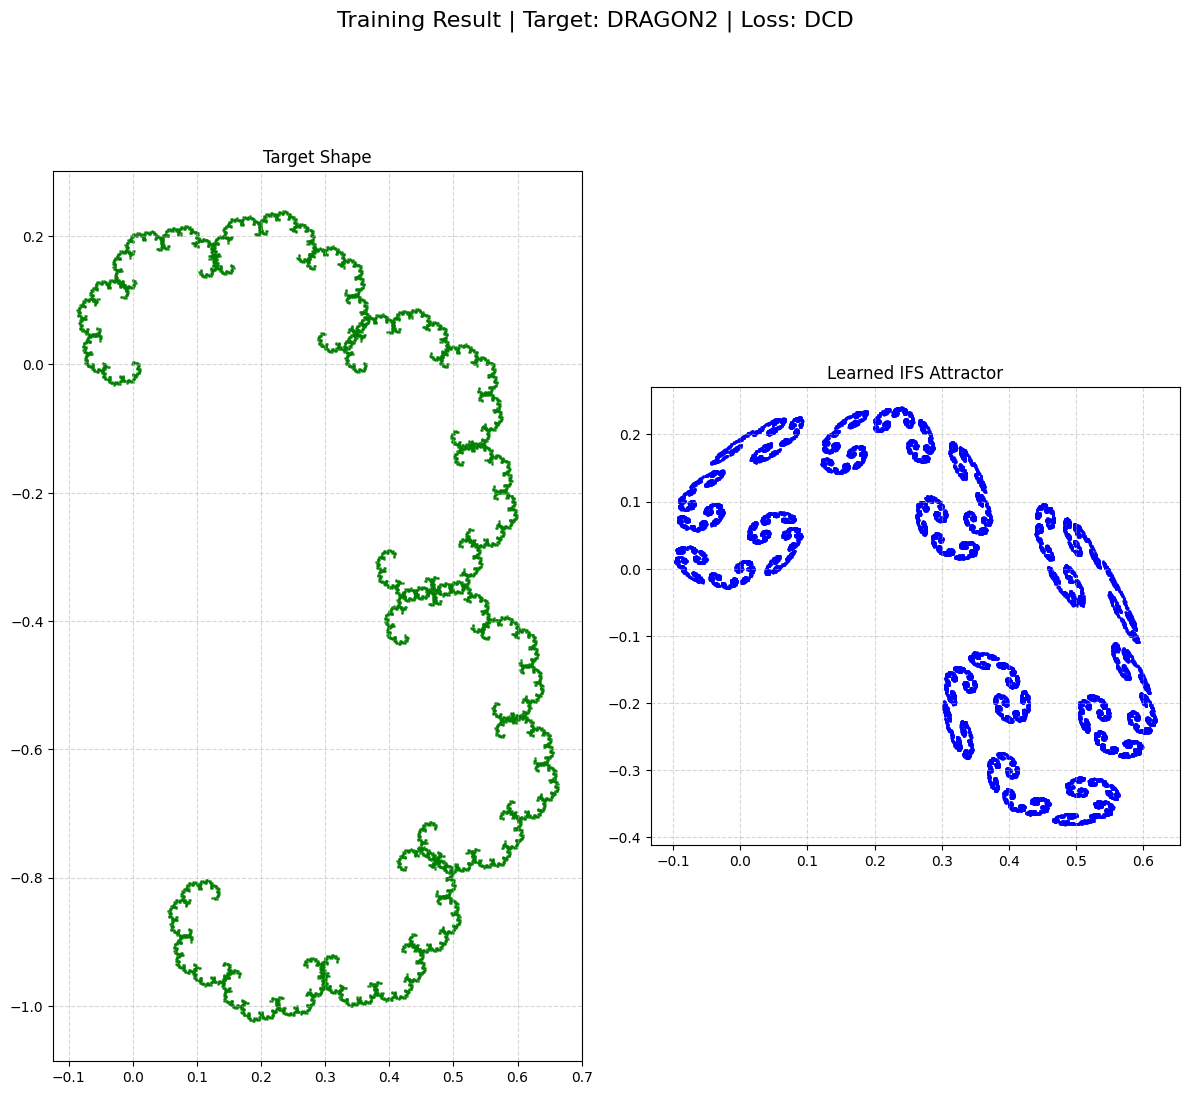

In [8]:
if __name__ == '__main__':
    # --- User Configuration Area ---

    # 1. Select target shape ('sierpinski', 'dragon', 'dragon2')
    TARGET_SHAPE = 'dragon2'

    # 2. Select loss function ('dcd', 'chamfer', 'multi_scale_chamfer')
    LOSS_FUNCTION = 'dcd'

    # 3. Set the number of IFS transforms
    NUM_IFS = 2

    # 4. Set the number of epochs for the two training stages
    SEARCH_EPOCHS = 1500 # Stage 1: Epochs for sigma search
    FINAL_EPOCHS = 500  # Stage 2: Epochs for final fine-tuning

    # 5. Set optimizer parameters
    LEARNING_RATE = 0.05
    NOISE_LEVEL = 0.01   # Noise level. Set to 0 to disable.

    # --- Experiment Setup (usually no changes needed) ---
    sigma_centers = [-1.0, 0.0, 1.0]
    sigma_combinations = list(combinations_with_replacement(sigma_centers, NUM_IFS))
    print("Generated Sigma Combinations for Initialization:")
    print(sigma_combinations)

    # --- Start Experiment ---
    final_model, target_point_cloud = run_training_experiment(
        target_shape=TARGET_SHAPE,
        loss_function_name=LOSS_FUNCTION,
        num_ifs=NUM_IFS,
        sigma_combinations=sigma_combinations,
        search_epochs=SEARCH_EPOCHS,
        final_epochs=FINAL_EPOCHS,
        learning_rate=LEARNING_RATE,
        noise_level=NOISE_LEVEL
    )

    # Print the final learned matrix A and bias b
    print("\n" + "="*50)
    print("                 Final Learned Parameters")
    print("="*50)
    final_model.to('cpu')
    with torch.no_grad():
        w_params = final_model.ifs_w.weight
        b_params = final_model.ifs_b.weight
        A_matrices = make_matrices_from_svdformat(w_params)

        print("\nLearned Affine Matrices (A):")
        for i, A in enumerate(A_matrices):
            print(f" A_{i}:\n{A.numpy()}")

        print("\nLearned Biases (b):")
        for i, b in enumerate(b_params):
            print(f" b_{i}:\n{b.numpy()}")
    print("="*50 + "\n")

    # --- Generate and display the final result ---
    learned_point_cloud = visualize_learned_ifs(final_model)

    fig, axs = plt.subplots(1, 2, figsize=(12, 12))
    fig.suptitle(f"Training Result | Target: {TARGET_SHAPE.upper()} | Loss: {LOSS_FUNCTION.upper()}", fontsize=16)

    axs[0].scatter(target_point_cloud[:, 0], target_point_cloud[:, 1], s=1, c='green', alpha=0.7)
    axs[0].set_title("Target Shape")
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].grid(True, linestyle='--', alpha=0.5)

    axs[1].scatter(learned_point_cloud[:, 0], learned_point_cloud[:, 1], s=1, c='blue', alpha=0.7)
    axs[1].set_title("Learned IFS Attractor")
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Generated Sigma Combinations for Initialization:
[(-1.0, -1.0, -1.0), (-1.0, -1.0, 0.0), (-1.0, -1.0, 1.0), (-1.0, 0.0, 0.0), (-1.0, 0.0, 1.0), (-1.0, 1.0, 1.0), (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (0.0, 1.0, 1.0), (1.0, 1.0, 1.0)]
--- Starting Experiment on device: cuda ---
Target: SIERPINSKI, Loss: CHAMFER, Num IFS: 3
LR: 0.05, Noise: 0.01

Generating target data...

--- STAGE 1: Searching for best initial sigma (10 combos) ---

--- Testing Combo 1/10: base_sigma = (-1.0, -1.0, -1.0) ---
   Epoch [500/2000], decaying LR...
   Epoch [1000/2000], decaying LR...
   Epoch [1000/2000], Loss (CHAMFER): 0.000023
   Epoch [1500/2000], decaying LR...
   Epoch [2000/2000], decaying LR...
   Epoch [2000/2000], Loss (CHAMFER): 0.000022

--- Testing Combo 2/10: base_sigma = (-1.0, -1.0, 0.0) ---
   Epoch [500/2000], decaying LR...
   Epoch [1000/2000], decaying LR...
   Epoch [1000/2000], Loss (CHAMFER): 0.000022
   Epoch [1500/2000], decaying LR...
   Epoch [2000/2000], decaying LR...
   Epoch [20

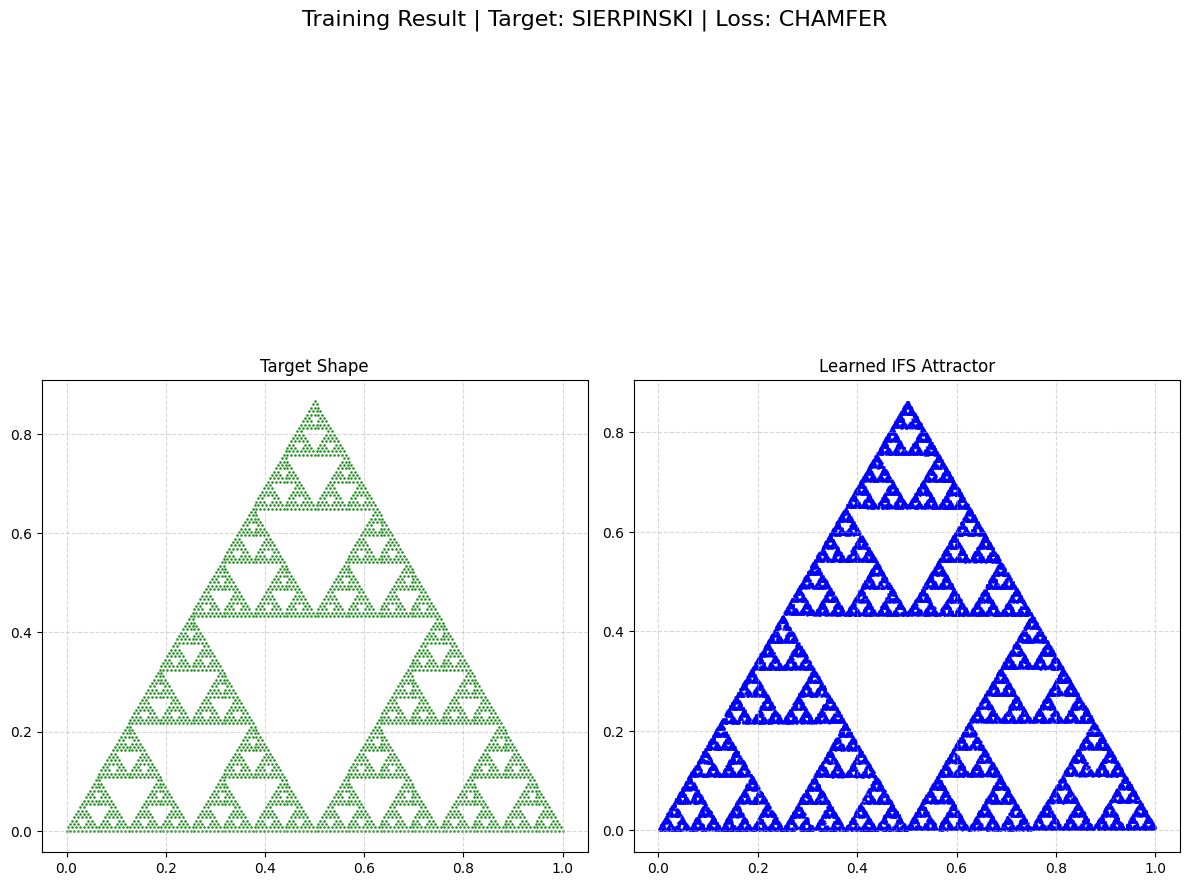

In [7]:
if __name__ == '__main__':
    # --- User Configuration Area ---

    # 1. Select target shape ('sierpinski', 'dragon', 'dragon2')
    TARGET_SHAPE = 'sierpinski'

    # 2. Select loss function ('dcd', 'chamfer', 'multi_scale_chamfer')
    LOSS_FUNCTION = 'chamfer'

    # 3. Set the number of IFS transforms
    NUM_IFS = 3

    # 4. Set the number of epochs for the two training stages
    SEARCH_EPOCHS = 2000 # Stage 1: Epochs for sigma search
    FINAL_EPOCHS = 3000  # Stage 2: Epochs for final fine-tuning

    # 5. Set optimizer parameters
    LEARNING_RATE = 0.05
    NOISE_LEVEL = 0.01   # Noise level. Set to 0 to disable.

    # --- Experiment Setup (usually no changes needed) ---
    sigma_centers = [-1.0, 0.0, 1.0]
    sigma_combinations = list(combinations_with_replacement(sigma_centers, NUM_IFS))
    print("Generated Sigma Combinations for Initialization:")
    print(sigma_combinations)

    # --- Start Experiment ---
    final_model, target_point_cloud = run_training_experiment(
        target_shape=TARGET_SHAPE,
        loss_function_name=LOSS_FUNCTION,
        num_ifs=NUM_IFS,
        sigma_combinations=sigma_combinations,
        search_epochs=SEARCH_EPOCHS,
        final_epochs=FINAL_EPOCHS,
        learning_rate=LEARNING_RATE,
        noise_level=NOISE_LEVEL
    )

    # Print the final learned matrix A and bias b
    print("\n" + "="*50)
    print("                 Final Learned Parameters")
    print("="*50)
    final_model.to('cpu')
    with torch.no_grad():
        w_params = final_model.ifs_w.weight
        b_params = final_model.ifs_b.weight
        A_matrices = make_matrices_from_svdformat(w_params)

        print("\nLearned Affine Matrices (A):")
        for i, A in enumerate(A_matrices):
            print(f" A_{i}:\n{A.numpy()}")

        print("\nLearned Biases (b):")
        for i, b in enumerate(b_params):
            print(f" b_{i}:\n{b.numpy()}")
    print("="*50 + "\n")

    # --- Generate and display the final result ---
    learned_point_cloud = visualize_learned_ifs(final_model)

    fig, axs = plt.subplots(1, 2, figsize=(12, 12))
    fig.suptitle(f"Training Result | Target: {TARGET_SHAPE.upper()} | Loss: {LOSS_FUNCTION.upper()}", fontsize=16)

    axs[0].scatter(target_point_cloud[:, 0], target_point_cloud[:, 1], s=1, c='green', alpha=0.7)
    axs[0].set_title("Target Shape")
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].grid(True, linestyle='--', alpha=0.5)

    axs[1].scatter(learned_point_cloud[:, 0], learned_point_cloud[:, 1], s=1, c='blue', alpha=0.7)
    axs[1].set_title("Learned IFS Attractor")
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()